<a href="https://colab.research.google.com/github/MarshaGomez/CNN-Medical-Imaging-Analysis/blob/main/Code/Scratch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Scratch CNN**
---
Classification model for discriminating between 2 classes: **masses and calcification**. *Ad-hoc CNN architecture*.

**Students:**   *A. Schiavo - M. Gómez - M. Daole*



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import os 

base_path = "/content/gdrive/My Drive/Colab_Notebooks/CIDL/DL Project/numpy data"
train_img_path = os.path.join(base_path, 'train_tensor.npy')
train_label_path = os.path.join(base_path, 'train_labels.npy')
test_img_path = os.path.join(base_path, 'public_test_tensor.npy')
test_label_path = os.path.join(base_path, 'public_test_labels.npy')

2.4.0


In [ ]:
# Load Arrays from Numpy Files
def load_training():
  train_images = np.load(train_img_path)
  train_labels = np.load(train_label_path)
  test_images = np.load(test_img_path)
  test_labels = np.load(test_label_path)

  return train_images, train_labels, test_images, test_labels

# Remove baseline samples
def remove_baseline(tensor): 
  max_ind = int(len(tensor)/2)
  indexes = [2*i + 1 for i in range(0, max_ind)]

  return tensor[indexes]

# Interchange the dataset index
def shuffle_dataset(x, y):
  indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
  shuffled_indices = tf.random.shuffle(indices)

  x = tf.gather(x, shuffled_indices)
  y = tf.gather(y, shuffled_indices)

  x = x.numpy()
  y = y.numpy()

  return x, y

In [ ]:
# Get images and labels (test, train)
train_images, train_labels, test_images, test_labels = load_training()

# Get abnormalities only 
train_images = remove_baseline(train_images)
train_labels = remove_baseline(train_labels)
test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)

# Suffle index (Previous dataset is ordered)
train_images, train_labels = shuffle_dataset(train_images, train_labels)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)


Train shape:  (2676, 150, 150)
Test shape:  (336, 150, 150)


## Data preprocessing

Currently, our data sits on a drive as numpy files (**.npy**), so the steps for getting it into our network are roughly:



In [ ]:
# Unify masses and calcifications 
def labels_mapping(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  idx = 0
  for label in labels:
    # masses
    if label == 1 or label == 2:
      labels_local[idx] = 0
    # calcifications
    else:
      labels_local[idx] = 1
    idx += 1

  return labels_local

labels = labels_mapping(train_labels)
test_labels = labels_mapping(test_labels)

In [ ]:
#print(train_labels[2000])
#print(labels[:10])
print(train_images.shape)

# verify values range: getting max value 
print(max([np.max(image) for image in train_images])) # max is 65'535 


(2676, 150, 150)
65535


In [ ]:
train_images = train_images.reshape(train_images.shape + (1,)) #(2676, 150, 150, 1)
test_images = test_images.reshape(test_images.shape + (1,)) #(2676, 150, 150, 1)
print(train_images.shape)
print(test_images.shape)

(2676, 150, 150, 1)
(336, 150, 150, 1)


In [ ]:
# split dataset into training and validation set 70-30
train_images_split = train_images[:int(0.7*len(train_images))]
valid_images_split = train_images[int(0.7*len(train_images)):]
train_labels_split = labels[:int(0.7*len(labels))]
valid_labels_split = labels[int(0.7*len(labels)):]

print(train_images_split.shape)
print(valid_images_split.shape)                                       

(1873, 150, 150, 1)
(803, 150, 150, 1)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./65535
train_datagen = ImageDataGenerator(rescale=1./65535)
valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

for batch, labels_batch in train_datagen.flow(train_images, labels, batch_size=BATCH_SIZE):
  print(batch.shape)
  print(labels_batch.shape)
  break



(20, 150, 150, 1)
(20,)


## Defining CNN 


In [ ]:
from keras import layers
from keras import optimizers 
from keras import models

def build_model(loss_function, eval_metric):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  #model.summary()

  model.compile(loss=loss_function,
              optimizer=optimizers.RMSprop(lr=1e-4), # lr = 0.0001
              metrics=[eval_metric]) 

In [ ]:
BATCH_SIZE = 20
EPOCHS = 100
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

## CNN Compilation:



In [ ]:
from keras import optimizers 

model = build_model("binary_crossentropy", "acc")

'\nmodel.compile(loss="binary_crossentropy",\n              optimizer=optimizers.RMSprop(lr=1e-4), # lr = 0.0001\n              metrics=["acc"]) \n'

In [ ]:
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)


Epoch 1/100
93/93 [==============================] - 10s 23ms/step - loss: 0.7000 - acc: 0.5354 - val_loss: 0.6897 - val_acc: 0.5412
Epoch 2/100
93/93 [==============================] - 2s 19ms/step - loss: 0.6756 - acc: 0.5850 - val_loss: 0.6481 - val_acc: 0.5437
Epoch 3/100
93/93 [==============================] - 2s 19ms/step - loss: 0.6204 - acc: 0.6681 - val_loss: 0.5625 - val_acc: 0.6500
Epoch 4/100
93/93 [==============================] - 2s 20ms/step - loss: 0.5096 - acc: 0.7716 - val_loss: 0.5009 - val_acc: 0.7525
Epoch 5/100
93/93 [==============================] - 2s 19ms/step - loss: 0.4617 - acc: 0.7993 - val_loss: 0.4876 - val_acc: 0.7862
Epoch 6/100
93/93 [==============================] - 2s 20ms/step - loss: 0.4341 - acc: 0.8186 - val_loss: 0.4694 - val_acc: 0.7725
Epoch 7/100
93/93 [==============================] - 2s 20ms/step - loss: 0.4318 - acc: 0.8126 - val_loss: 0.5124 - val_acc: 0.7763
Epoch 8/100
93/93 [==============================] - 2s 20ms/step - loss: 0

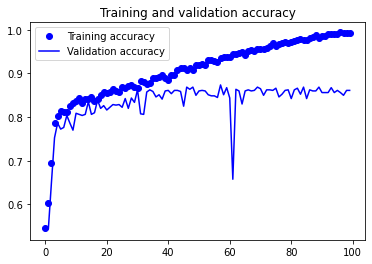

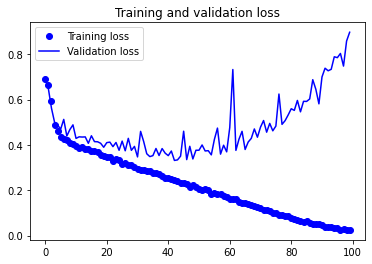

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 8ms/step - loss: 1.1820 - acc: 0.8250
0.824999988079071


These plots are characteristic of **overfitting**. Training accuracy keeps increasing linearly while validation accuracy stalls around **82%**.

##Fighting overfitting: 1. Data Augmentation:


In [ ]:
from tensorflow.keras.preprocessing import image

# train data augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

"""
x = train_images[0].reshape((1,) + train_images[0].shape)

i = 0
for batch in train_datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i % 4 == 0:
    break

plt.show()
"""

'\nx = train_images[0].reshape((1,) + train_images[0].shape)\n\ni = 0\nfor batch in train_datagen.flow(x, batch_size=1):\n  plt.figure(i)\n  imgplot = plt.imshow(image.array_to_img(batch[0]))\n  i += 1\n  if i % 4 == 0:\n    break\n\nplt.show()\n'

In [ ]:
model = build_model("binary_crossentropy", "acc")

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [ ]:
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
93/93 [==============================] - 5s 44ms/step - loss: 0.6955 - acc: 0.5130 - val_loss: 0.6879 - val_acc: 0.5412
Epoch 2/100
93/93 [==============================] - 4s 41ms/step - loss: 0.6901 - acc: 0.5454 - val_loss: 0.6691 - val_acc: 0.6800
Epoch 3/100
93/93 [==============================] - 4s 41ms/step - loss: 0.6728 - acc: 0.5767 - val_loss: 0.6263 - val_acc: 0.7725
Epoch 4/100
93/93 [==============================] - 4s 41ms/step - loss: 0.6195 - acc: 0.7073 - val_loss: 0.5396 - val_acc: 0.7987
Epoch 5/100
93/93 [==============================] - 4s 41ms/step - loss: 0.5931 - acc: 0.7009 - val_loss: 0.5582 - val_acc: 0.7650
Epoch 6/100
93/93 [==============================] - 4s 41ms/step - loss: 0.5327 - acc: 0.7640 - val_loss: 0.5157 - val_acc: 0.7738
Epoch 7/100
93/93 [==============================] - 4s 41ms/step - loss: 0.5451 - acc: 0.7612 - val_loss: 0.4915 - val_acc: 0.8050
Epoch 8/100
93/93 [==============================] - 4s 41ms/step - loss: 0.

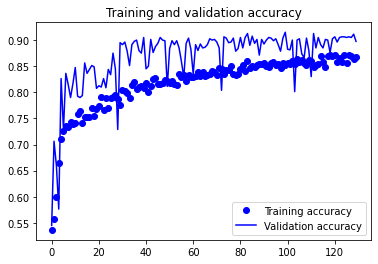

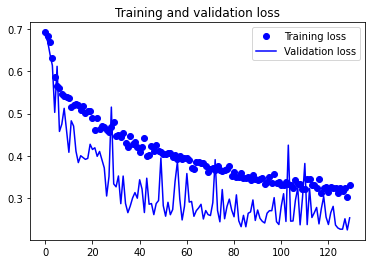

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 8ms/step - loss: 0.3443 - acc: 0.8531
0.8531249761581421


##K-fold cross validation.
